In [1]:
import numpy as np, scipy as sp
from matplotlib import pyplot as p
import scipy.stats

In [2]:
%load_ext cython

In [3]:
%load_ext line_profiler
import line_profiler

In [66]:
%%cython -c=-O3
#don't #cython: linetrace=True
#don't # distutils: define_macros=CYTHON_TRACE=1
# remove "don't" above to do the line profiling

"""This module stabilizes sandpile configurations on a line with sinks at both ends.

The configurations are described in two different ways.

chip format: a list of the number of chips at each site ([0, 0, 0, 0, 0, 1, 1, ...])
chip-antichip format:
    we imagine that every site starts with one chip, and then provide a length L and two lists [1, 2, 3, ...], [4, 5, 6, ...].
    the first one gives locations where an extra chip is added; the second one gives locations where an extra chip is subtracted.
"""

import numpy as np

cimport numpy as np

DEBUG = False

class twosandzeros:
    def __init__(self, length, twos, zeros):
        self.length = length
        self.twos = np.array(twos, dtype=int)
        self.zeros = np.array(zeros, dtype=int)
        self.validator()

    def validator(self):
        length = self.length
        twos = self.twos
        zeros = self.zeros
        
        # make sure that the assumptions of the algorithm are valid because otherwise
        # who knows what could happen
        if length < 0:
            raise AssertionError("length must be nonnegative, but it's %d" % length)
        
        def firstfalse(array):
            if array.size == 0:
                # trivially no false
                # (and if we don't do this then argmin will raise an exception)
                return None
            j = np.argmin(array)
            return None if array[j] else j
        
        def validate(name, array):
            # make sure they are all between 0 and length
            i = firstfalse(np.logical_and(array >= 0, array < length))
            if i is not None:
                raise AssertionError("%s in an invalid position: %d (#%d)" % (name, array[i], i))
            
            i = firstfalse(array[:-1] <= array[1:])
            if i is not None:
                raise AssertionError("%ss are not sorted: %d (#%d) > %d (#%d)" % (name, array[i], i, array[i+1], i+1))
        
        validate("two", twos)
        validate("zero", zeros)

    @staticmethod
    def fromchip(chiplist):
        l = len(chiplist)
        chiplist = np.array(chiplist, dtype=int)
        al = np.arange(l)
        twos = np.repeat(al, np.maximum(0, chiplist - 1))
        zeros = np.repeat(al, np.maximum(0, 1 - chiplist))
        return twosandzeros(l, twos, zeros)

    def tochip(self):
        # possibly premature optimization
        cdef int i
        cdef np.ndarray[int, ndim=1] twos = self.twos
        cdef np.ndarray[int, ndim=1] zeros = self.zeros
        cdef np.ndarray[int, ndim=1] chip = np.ones(self.length, dtype=np.int)
        if DEBUG:
            print(twos, zeros)
        for i in range(len(twos)):
            chip[twos[i]] += 1
        for i in range(len(zeros)):
            chip[zeros[i]] -= 1
        return chip

class stabilize:
    @staticmethod
    def slow(chiplist):
        "A slow implementation of sandpile stabilization for testing."
        chiplist = np.array(chiplist, dtype=np.int)
        cdef int[:] chip = chiplist
        cdef int sink_l = 0
        cdef int sink_r = 0
        cdef int stop = True
        cdef int i
        while True:
            stop = True
            for i in range(len(chip)):
                if chip[i] > 1:
                    chip[i] -= 2
                    if i > 0:
                        chip[i-1] += 1
                    else:
                        sink_l += 1
                    if i < len(chip) - 1:
                        chip[i+1] += 1
                    else:
                        sink_r += 1
                    stop = False
            if stop:
                break
        return chiplist, sink_l, sink_r

    @staticmethod
    def _fst(twosandzeros):
        "Implementation of the algorithm in Nilsson and Moore's paper."
        cdef int length = twosandzeros.length
        cdef np.ndarray[int, ndim=1] twos = twosandzeros.twos
        cdef np.ndarray[int, ndim=1] zeros = twosandzeros.zeros.copy()

        # We will store two separate stacks of zeros.
        # The first one contains the zeroes that are left of our notional current position.
        # Those are stored in zeros[0:zeroptr1].
        # The second one contains the zeroes that are right of us, which are stored in zeros[zeroptr2:].
        cdef int zeroptr1 = 0
        cdef int zeroptr2 = 0

        if len(zeros) == 0:
            # there are no zeros, but we want to have room for at least one zero
            zeros = np.zeros(1, dtype=int)
            # but both stacks are still empty
            zeroptr1 = 0
            zeroptr2 = len(zeros)

        cdef int twoptr = 0
        cdef int zeroleft, zeroright, newzero
        cdef int sink_l = 0
        cdef int sink_r = 0

        for twoptr in range(len(twos)):
            #if DEBUG:
            #    print("zeros:", zeros[:zeroptr1], zeros[zeroptr2:])
            #    print("two:", twos[twoptr])

            if zeroptr2 < zeroptr1:
                raise AssertionError("pointers are in the wrong order: %d > %d" % (zeroptr1, zeroptr2))
            # if the top zero on the second stack is to our left, move it to the first stack
            while zeroptr2 < len(zeros) and twos[twoptr] > zeros[zeroptr2]:
                zeros[zeroptr1] = zeros[zeroptr2]
                zeroptr1 += 1
                zeroptr2 += 1

            # now the nearest zeros on both stacks should be to our left and right.
            # if there is a zero at our position, we just delete it and go back to the start.
            if zeroptr2 < len(zeros) and zeros[zeroptr2] == twos[twoptr]:
                zeroptr2 += 1
                continue

            # otherwise, we pop the nearest zeros off of both of the stacks.
            if zeroptr1 > 0:
                zeroleft = zeros[zeroptr1 - 1]
                # pop
                zeroptr1 -= 1
            else:
                # there are no zeros to the left, so the 'top zero' is the sink on that side.
                zeroleft = -1
                # a chip will fall into the sink, so we increase sink_l by 1
                sink_l += 1

            if zeroptr2 < len(zeros):
                zeroright = zeros[zeroptr2]
                # pop
                zeroptr2 += 1
            else:
                # there are no zeros to the right, so the 'top zero' is the sink on that side.
                zeroright = length
                # a chip will fall into the sink, so we increase sink_r by 1
                sink_r += 1

            # add a new zero and push it on the second stack.
            # (it may be left of our notional position, so we might be putting it in the wrong stack,
            # but this is fine because we will move it to the first stack at the start of the loop.)
            # the total number of zeros stays the same or decreases UNLESS there are no zeros at all,
            # in which case we add one zero. this is why we needed to make room for at least
            # one zero.
            #if DEBUG:
            #    print("zlzr:", zeroleft, zeroright, twos[twoptr])

            newzero = zeroleft + zeroright - twos[twoptr]
            zeroptr2 -= 1
            assert zeroptr2 >= 0
            zeros[zeroptr2] = newzero
            #if DEBUG:
            #    print("zeros:", zeros[:zeroptr1], zeros[zeroptr2:])
            #    print()

        # combine the stacks
        out = np.concatenate([zeros[:zeroptr1], zeros[zeroptr2:]])
        return (out, sink_l, sink_r)
    
    @staticmethod
    def fast(chiplist):
        twaz = twosandzeros.fromchip(chiplist)
        zeros, sink_l, sink_r = stabilize._fst(twaz)
        return twosandzeros(twaz.length, [], zeros).tochip(), sink_l, sink_r


In [67]:
import unittest

def check_if_fast_and_slow_are_equal(chip):
    fast = stabilize.fast(chip)
    slow = stabilize.slow(chip)
    return np.all(fast[0] == slow[0]) and fast[1] == slow[1] and fast[2] == slow[2]

class TestSand(unittest.TestCase):
    def test_short(self):
        what = [
            [],
            [0],
            [7],
            [0, 2, 0],
            [0, 0, 0, 0, 0, 0, 99],
            [0, 2, 0, 2],
            [2] * 120
        ]
        for chip in what:
            self.assertTrue(check_if_fast_and_slow_are_equal(chip))
    
    def test_random_uniform(self):
        def one():
            lent = np.random.randint(0, 400)
            maximum = np.random.choice([1, 2, 3])
            rand = np.random.randint(0, maximum, lent)
            return check_if_fast_and_slow_are_equal(rand)
            
        for j in range(1000):
            self.assertTrue(one())

    def test_random_poisson(self):
        def one():
            lent = np.random.randint(0, 400)
            mu = np.random.random() * 2 + 1
            rand = np.random.poisson(mu, lent)
            return check_if_fast_and_slow_are_equal(rand)
            
        for j in range(1000):
            self.assertTrue(one())

unittest.main(argv=[''], verbosity=2, exit=False)

test_random_poisson (__main__.TestSand) ... ok
test_random_uniform (__main__.TestSand) ... ok
test_short (__main__.TestSand) ... ok

----------------------------------------------------------------------
Ran 3 tests in 5.418s

OK


In [133]:
import time
#speed test

print("slow simulator")
def slowtest():
    t = time.time()
    for j in range(1000):
        lent = np.random.randint(0, 4000)
        maximum = np.random.choice([2, 3, 4])
        rand = np.random.randint(0, maximum, lent)
        stabilize.slow(rand)
    print(time.time() - t)
slowtest()

print("fast simulator")
def fasttest():
    t = time.time()
    for j in range(1000):
        lent = np.random.randint(0, 4000)
        maximum = np.random.choice([2, 3, 4])
        rand = np.random.randint(0, maximum, lent)
        stabilize.fast(rand)
    print(time.time() - t)
fasttest()

slow simulator


KeyboardInterrupt: 

In [163]:
# try and stabilize a really long line
length = 100000000
shift = 0
probabilities = [1/3, 1/3 - shift, 1/3 + shift]
print("generating a line of length %d, probabilities %s" % (length, probabilities))
what = np.random.choice(len(probabilities), length, p=probabilities)
print("The input density is %f" % np.mean(what))

generating a line of length 100000000, probabilities [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
The input density is 1.000033


In [164]:
print("The first part of the input array is")
print(what[:90])

The first part of the input array is
[2 1 1 1 1 1 2 0 2 1 1 2 0 1 1 0 1 0 2 0 0 1 0 2 2 2 1 1 0 2 0 1 1 1 0 2 0
 2 1 1 0 0 0 0 2 2 0 0 0 0 0 0 1 0 2 2 1 0 0 1 0 0 2 1 0 2 2 0 1 2 0 0 0 2
 1 2 1 0 2 1 2 2 1 0 0 0 2 2 1 2]


In [167]:
import time
t = time.time()
print("Calculating stabilization...")
out = stabilize.fast(what)
print("Stabilized in %f seconds." % (time.time() - t))
print("The first part of the output array is")
print(out[0][:90])
print("%d chips fell on the left sink and %d chips fell on the right sink" % (out[1], out[2]))


Calculating stabilization...
Stabilized in 3.508701 seconds.
The first part of the output array is
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
4635 chips fell on the left sink and 2519 chips fell on the right sink


There are 3846 zeros.
The density is 0.000038460.
Histogram of zero locations:


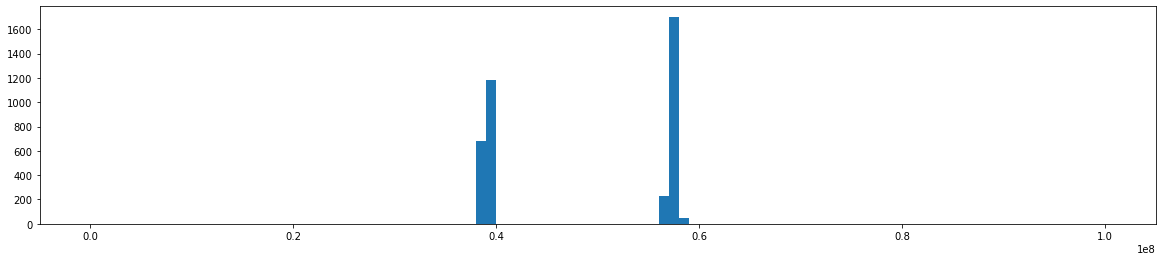

This is 100 bins each containing 1000000 sites.
For comparison, a histogram of random zeros at this density looks like


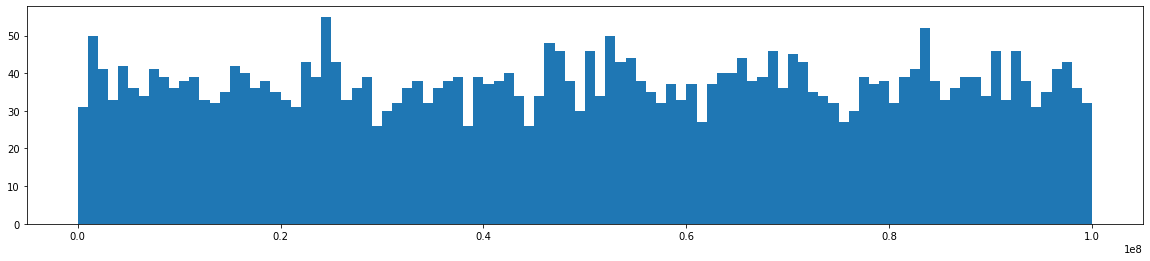

In [166]:
zeros = np.where(out[0] == 0)[0]
nzeros = len(zeros)
if nzeros != 1:
    print("There are %d zeros." % nzeros)
else:
    print("There is one zero.")
print("The density is %.9f." % (len(zeros) / length))
print("Histogram of zero locations:")
def hist(it):
    number_of_bins = 100
    bins = list(range(0, length + 1, length // number_of_bins))
    p.figure(figsize=(20, 4))
    p.hist(it, bins=bins)
    p.show()
hist(zeros)
print("This is %d bins each containing %d sites." % (number_of_bins, bins[1] - bins[0]))
print("For comparison, a histogram of random zeros at this density looks like")
density = len(zeros)/length
random_config = np.random.choice(2, length, p=[density, 1-density])
random_zeros = np.where(random_config == 0)[0]
hist(random_zeros)


In [69]:
import cProfile
cProfile.run("fasttest()")


0.15915727615356445
         65905 function calls in 0.160 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4552    0.003    0.000    0.015    0.000 <__array_function__ internals>:2(argmin)
     1000    0.001    0.000    0.003    0.000 <__array_function__ internals>:2(concatenate)
     1000    0.001    0.000    0.003    0.000 <__array_function__ internals>:2(copyto)
     1000    0.001    0.000    0.012    0.000 <__array_function__ internals>:2(prod)
     2000    0.001    0.000    0.025    0.000 <__array_function__ internals>:2(repeat)
        1    0.072    0.072    0.160    0.160 <ipython-input-68-6872d1643e50>:16(fasttest)
        1    0.000    0.000    0.160    0.160 <string>:1(<module>)
     4552    0.001    0.000    0.001    0.000 fromnumeric.py:1191(_argmin_dispatcher)
     4552    0.003    0.000    0.010    0.000 fromnumeric.py:1195(argmin)
     1000    0.000    0.000    0.000    0.000 fromnumeric.py:2876(_prod_di

In [70]:
bar = np.zeros(4)
np.add.at(bar, [0, 1, 1, 1], 1)
bar

array([1., 3., 0., 0.])

In [71]:
profile = line_profiler.LineProfiler(twosandzeros.fromchip)
profile.run("fasttest()")
profile.print_stats()

0.15927457809448242
Timer unit: 1e-07 s

Total time: 0 s
File: C:\Users\cola\.ipython\cython\_cython_magic_2b447ae1507445880aeef3a5d3a7188c.pyx
Function: fromchip at line 59

Line #      Hits         Time  Per Hit   % Time  Line Contents
    59                                               def fromchip(chiplist):
    60                                                   l = len(chiplist)
    61                                                   chiplist = np.array(chiplist, dtype=int)
    62                                                   al = np.arange(l)
    63                                                   twos = np.repeat(al, np.maximum(0, chiplist - 1))
    64                                                   zeros = np.repeat(al, np.maximum(0, 1 - chiplist))
    65                                                   return twosandzeros(l, twos, zeros)



In [72]:
profile = line_profiler.LineProfiler(stabilize._fst)
profile.run("fasttest()")
profile.print_stats()

0.1601419448852539
Timer unit: 1e-07 s

Total time: 0 s
File: C:\Users\cola\.ipython\cython\_cython_magic_2b447ae1507445880aeef3a5d3a7188c.pyx
Function: _fst at line 110

Line #      Hits         Time  Per Hit   % Time  Line Contents
   110                                               def _fst(twosandzeros):
   111                                                   "Implementation of the algorithm in Nilsson and Moore's paper."
   112                                                   cdef int length = twosandzeros.length
   113                                                   cdef np.ndarray[int, ndim=1] twos = twosandzeros.twos
   114                                                   cdef np.ndarray[int, ndim=1] zeros = twosandzeros.zeros.copy()
   115                                           
   116                                                   # We will store two separate stacks of zeros.
   117                                                   # The first one contains the zer